(7000, 6) (7000,)
14
error rate:  0.014


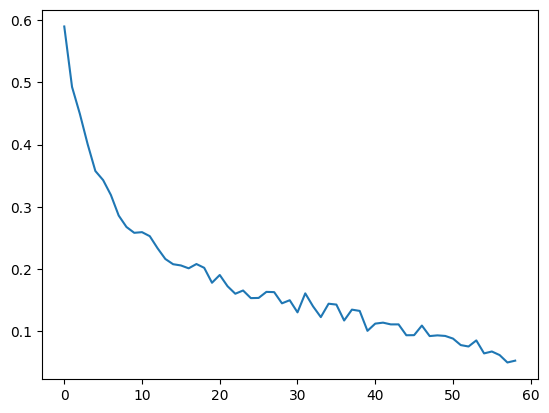

1
error rate:  0.001


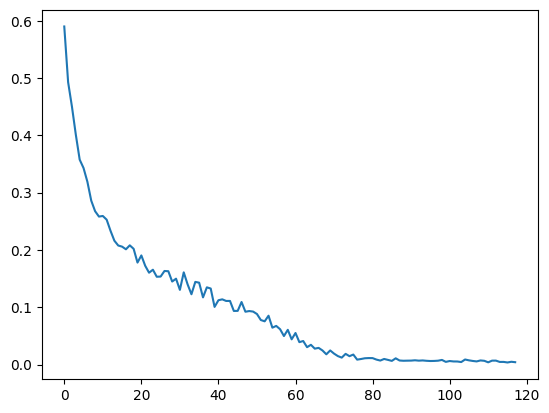

KeyboardInterrupt: 

In [15]:
import scipy
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
from model import MLP
from fasterkan.fasterkan import FasterKAN, FasterKANvolver
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import sklearn.metrics as metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_nums = 6000
# 模型选择KAN MLP
architecture = "KAN"
# 迭代次数
num_epochs = 100
losses = []

i = 0
dataset_x = []
dataset_y = []  # 列表
for filename in ["feipo1", "po2"]:

    mat = scipy.io.loadmat(filename)["po"]
    # 删除nan的列
    nan_mask = np.isnan(mat)
    row_with_nan = np.any(nan_mask, axis=1)
    mat = mat[~row_with_nan]
    mat = mat[:3500, :]
    shuffle_index = np.random.permutation(mat.shape[0])
    mat = mat[shuffle_index]
    dataset_x.append(mat)
    dataset_y.append(np.ones(mat.shape[0]) * i)
    i = i + 1
dataset_x = np.concatenate(dataset_x, axis=0)
dataset_y = np.concatenate(dataset_y, axis=0)
print(dataset_x.shape, dataset_y.shape)

# 打乱dataset
np.random.seed(0)
shuffle_index = np.random.permutation(dataset_x.shape[0])
dataset_x = dataset_x[shuffle_index]
dataset_y = dataset_y[shuffle_index]

regression = False


class TensorDataset(Dataset):
    def __init__(self, data, label, regression: bool = regression):
        self.data = data
        if regression:
            self.label = label
        else:
            self.label = torch.eye(2)[label.long()] # one-hot

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return (self.data[index],
                self.label[index])
batch_size = 128
dataset = TensorDataset(torch.tensor(dataset_x[:sample_nums], dtype=torch.float32),
                        torch.tensor(dataset_y[:sample_nums], dtype=torch.float32))
collect_fn = lambda x: (torch.stack([i[0] for i in x]), torch.stack([i[1] for i in x]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collect_fn)

testdata = TensorDataset(torch.tensor(dataset_x[sample_nums:], dtype=torch.float32),
                         torch.tensor(dataset_y[sample_nums:], dtype=torch.float32))
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=False, collate_fn=collect_fn)


num_hidden = 512;
bool_flag = True
dim_in = 6
if regression:
    dim_out = 1
else:
    dim_out = 2
if architecture == "MLP":
    model = MLP(dim_in=dim_in, dim_out= dim_out, hidden_dim=num_hidden, hidden_num=4)
if architecture == "KAN":
    model = FasterKAN([dim_in, num_hidden, dim_out], grid_min=-1.2, grid_max=0.2, num_grids=8, exponent=2, inv_denominator=0.5,
                      train_grid=bool_flag, train_inv_denominator=bool_flag)

model.to(device)
# 定义损失函数和优化器
# mse
#criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,3]))
from model import FocalLoss
criterion = FocalLoss(gamma=1.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# 训练模型

def class_error(outputs, labels):
    predict = torch.argmax(outputs, dim=1)
    label = torch.argmax(labels, dim=1)
    return torch.sum(predict != label).item()
error = class_error

sigmoid = nn.Sigmoid()
# 每n个数据取平均
def average_n(data : np.ndarray, n = 8):
    data_ = []
    for i in range(0, len(data), n):
        data_.append(np.mean(data[i:i+n], axis=0))
    return np.array(data_)
for epoch in range(num_epochs):
    for batch in dataloader:
        # 前向传播
        inputs = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(inputs)
        outputs = sigmoid(outputs) # 这里将输出变成了概率
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # validate
        errors = 0;
        for batch in testloader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(inputs)
            errors += error(outputs, labels)
        print(errors)
        print("error rate: ", errors / len(testdata))

        plt.plot(average_n(losses, n=8))
        plt.show()





opt = []
y_true = []
for batch in testloader:
    inputs = batch[0].to(device)
    labels = batch[1].to(device)
    outputs = model(inputs)
    opt.append(outputs.cpu().detach().numpy())
    y_true.append(labels.cpu().detach().numpy())
opt = np.concatenate(opt, axis=0)
y_true = np.concatenate(y_true, axis=0)
def to_class(x):
    return np.argmax(x, axis=1)
opt = to_class(opt)
y_true = to_class(y_true)
cm = metrics.confusion_matrix(y_true, opt, labels=None, sample_weight=None, normalize=None)
# 设置figure大小
plt.figure(figsize=(3, 3))
# 绘制混淆矩阵
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
# 设置坐标轴标签
tick_marks = np.arange(len(set(y_true)))
plt.xticks(tick_marks, ['feipo','po'], rotation=45)
plt.yticks(tick_marks, ['feipo','po'])

# 在格子里添加数值
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# 设置坐标轴标签
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



In [1]:
dataset = TensorDataset(torch.tensor(dataset_x[:sample_nums], dtype=torch.float32), torch.tensor(dataset_y[:sample_nums], dtype=torch.float32)
                        , regression=True)
collect_fn = lambda x: (torch.stack([i[0] for i in x]), torch.stack([i[1] for i in x]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collect_fn)

testdata = TensorDataset(torch.tensor(dataset_x[sample_nums:], dtype=torch.float32), torch.tensor(dataset_y[sample_nums:], dtype=torch.float32),
                         regression=True)
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=False, collate_fn=collect_fn)
architecture = "KAN"
num_hidden = 1024; bool_flag = True
dim_in = 6
if architecture == "MLP":
    model = MLP(dim_in = dim_in, dim_out =1, hidden_dim=num_hidden, hidden_num=3)
if architecture == "KAN":
    model = FasterKAN([dim_in, num_hidden,  1], grid_min = -1.2, grid_max = 0.2, num_grids = 8, exponent = 2, inv_denominator = 0.5, train_grid = bool_flag, train_inv_denominator = bool_flag)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# 定义损失函数和优化器
# mse
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
from matplotlib import pyplot as plt
# 训练模型
num_epochs = 100
losses = []
def reg_error(outputs, labels):
    return torch.sum(torch.abs(outputs - labels) > 0.5).item()

error = reg_error
for epoch in range(num_epochs):
    for batch in dataloader:
        # 前向传播
        inputs = batch[0].to(device)
        labels = batch[1].reshape(-1,1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    
    
    if (epoch+1) % 10 == 0:
    
        # validate
        errors = 0;
        for batch in testloader:
            inputs = batch[0].to(device)
            labels =  batch[1].reshape(-1,1).to(device)
            outputs = model(inputs)
            errors += error(outputs, labels)
        print(errors)

        print("error rate: ", errors / len(testdata))
        
        plt.plot(losses)
        plt.show()


NameError: name 'TensorDataset' is not defined